## Using Natural Language Processing Pipeline to Investigate Amazon Review Data.

In [1]:
# Importing packages
# General packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Web scraping packages
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options
import time
from time import sleep
from bs4 import BeautifulSoup as BS
from selenium.webdriver.edge.service import Service

# Text analysis packages
from collections import Counter
import nltk
from textblob import Word
import string
import numpy as np

# Sentiment analysis packages
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#### Data Creation and Pre-Processing – 

In [2]:
# Scraping data from Amazon website
# Creating lists to store scraped data
body_list = []
title_list1 = []
rating_list1 = []
asin_list = []
date_list1 = []

# List of ASINs to scrape data from
asins = ['B0BH7VSYVZ', 'B01N5XZCTV', 'B09ZHLXPNQ', #books
         'B09Q86F1BT', 'B0822KRN8Q', 'B0CWHL3ZQM', #clothes
         'B08J1XD1JM', 'B0BTTM9X51', 'B0CXTPK12L', #household
         'B09LS3M222', 'B07CTSS14R', 'B01IW02HX2', #personal care
         'B0CXJDX8XY', 'B08C7KG5LP', 'B0BRKJNRGT'] #technology

# For each ASIN in list, use webdriver and beautiful soup to retrieve body, title, rating, and date
for asin in asins:
    service = Service(r"C:\Users\holly\msedgedriver.exe") # needs to be location of where driver is installed
    driver = webdriver.Edge(service=service)
    driver.get(f"https://www.amazon.co.uk/product-reviews/{asin}/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews&sortBy=recent")
    driver.maximize_window()
    source = driver.page_source
    soup = BS(source, 'html.parser')
    # Data to retrieve
    body = soup.find_all('span', {'data-hook': 'review-body'})
    title = soup.find_all('a', {'data-hook': 'review-title'})
    rating = soup.find_all('i', {'data-hook': 'review-star-rating'})
    date = soup.find_all('span', {'data-hook': 'review-date'})
    # Printing product scraped from (show progress)
    print("Scraping ASIN: " + str(asin))
    
    # Add ASIN to list
    asin_list.extend([asin]*len(body))
    
    # Adding scraped data to lists
    for i in body:
        body_list.append(i.get_text(strip=True)) 
    for i in title:
        title_list1.append(i.get_text(strip=True))
    for i in rating:
        rating_list1.append(i.get_text(strip=True))
    for i in date:
        date_list1.append(i.get_text(strip=True))
    
    # Adding time break to mimic human behaviour - so don't overload system
    time.sleep(5)
# Closing webdriver
driver.close()

Scraping ASIN: B0BH7VSYVZ
Scraping ASIN: B01N5XZCTV
Scraping ASIN: B09ZHLXPNQ
Scraping ASIN: B09Q86F1BT
Scraping ASIN: B0822KRN8Q
Scraping ASIN: B0CWHL3ZQM
Scraping ASIN: B08J1XD1JM
Scraping ASIN: B0BTTM9X51
Scraping ASIN: B0CXTPK12L
Scraping ASIN: B09LS3M222
Scraping ASIN: B07CTSS14R
Scraping ASIN: B01IW02HX2
Scraping ASIN: B0CXJDX8XY
Scraping ASIN: B08C7KG5LP
Scraping ASIN: B0BRKJNRGT


In [3]:
# Filtering scraped text to get desired text only
# Adding title to list
title_list2 = []
for title in title_list1:
    # Getting title text only
    star_rating, title_text = title.split('stars', 1)
    title_list2.append(title_text.strip())

# Adding star ratings to list
rating_list2 = []
for rating in rating_list1:
    # Getting number value only
    star, star_text = rating.split('.', 1)
    rating_list2.append(star.strip())
    
# Adding dates to list
date_list2 = []
for date in date_list1:
    # Getting date only
    date_text, date = date.split('on ', 1)
    date_list2.append(date.strip())

In [4]:
# Putting scraped data (from lists) into a pandas dataframe
data = {'asin': asin_list,
        'review_title': title_list2,
        'rating': rating_list2,
        'review_body': body_list,
        'review_date': date_list2
}
df = pd.DataFrame(data)
# Printing sample of dataframe
df.sample(5, random_state=123)

,asin,review_title,rating,review_body,review_date
72,B0BTTM9X51,Laundry,5,Great product,4 June 2024
112,B01IW02HX2,Good mix of colours,5,Great quality and great mix of cours,26 May 2024
132,B08C7KG5LP,Annoying if you switch devices often,4,Sound quality and useability is through the ro...,2 June 2024
88,B0CXTPK12L,So far so good!,5,It’s a bit more complicated than my previous a...,31 May 2024
37,B09Q86F1BT,Good wellie boots,4,Good quality just need to be worn in a little bit,29 May 2024


In [5]:
# Combining review title and review body columns
df['review_text'] = df['review_title'] + ' ' + df['review_body']
df.drop(['review_title', 'review_body'], axis=1, inplace=True)

In [6]:
# Checking length of dataframe
len(df)

150

In [7]:
# Checking datatypes and missing data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   asin         150 non-null    object
 1   rating       150 non-null    object
 2   review_date  150 non-null    object
 3   review_text  150 non-null    object
dtypes: object(4)
memory usage: 4.8+ KB


In [8]:
# Changing data types to as desired
df['rating'] = df['rating'].astype(int)
df['review_date'] = pd.to_datetime(df['review_date'], format='%d %B %Y')

In [9]:
# Checking data types after changes made
df.dtypes

asin                   object
rating                  int32
review_date    datetime64[ns]
review_text            object
dtype: object

In [10]:
# Saving dataframe to excel - save time regenerating and ensure consistent results
df.to_excel("Amazon Review Data.xlsx", index=False)

In [12]:
# Redefining dataframe as excel download to ensure consistency
data = pd.read_excel("Amazon Review Data.xlsx")
df = pd.DataFrame(data)
df.head()

,asin,rating,review_date,review_text
0,B0BH7VSYVZ,5,2024-06-06,wow! Woah! What a rollercoaster of a book!It w...
1,B0BH7VSYVZ,2,2024-06-06,Poor writing Lack of any character depth or a ...
2,B0BH7VSYVZ,5,2024-06-05,"Amazing!! Amazing book, had me gripped from th..."
3,B0BH7VSYVZ,5,2024-06-05,Great story I loved this book. Lisa Jewell has...
4,B0BH7VSYVZ,5,2024-06-04,Brilliant What a cracker of a book. Lisa Jewe...


#### Pre-Processing and EDA -

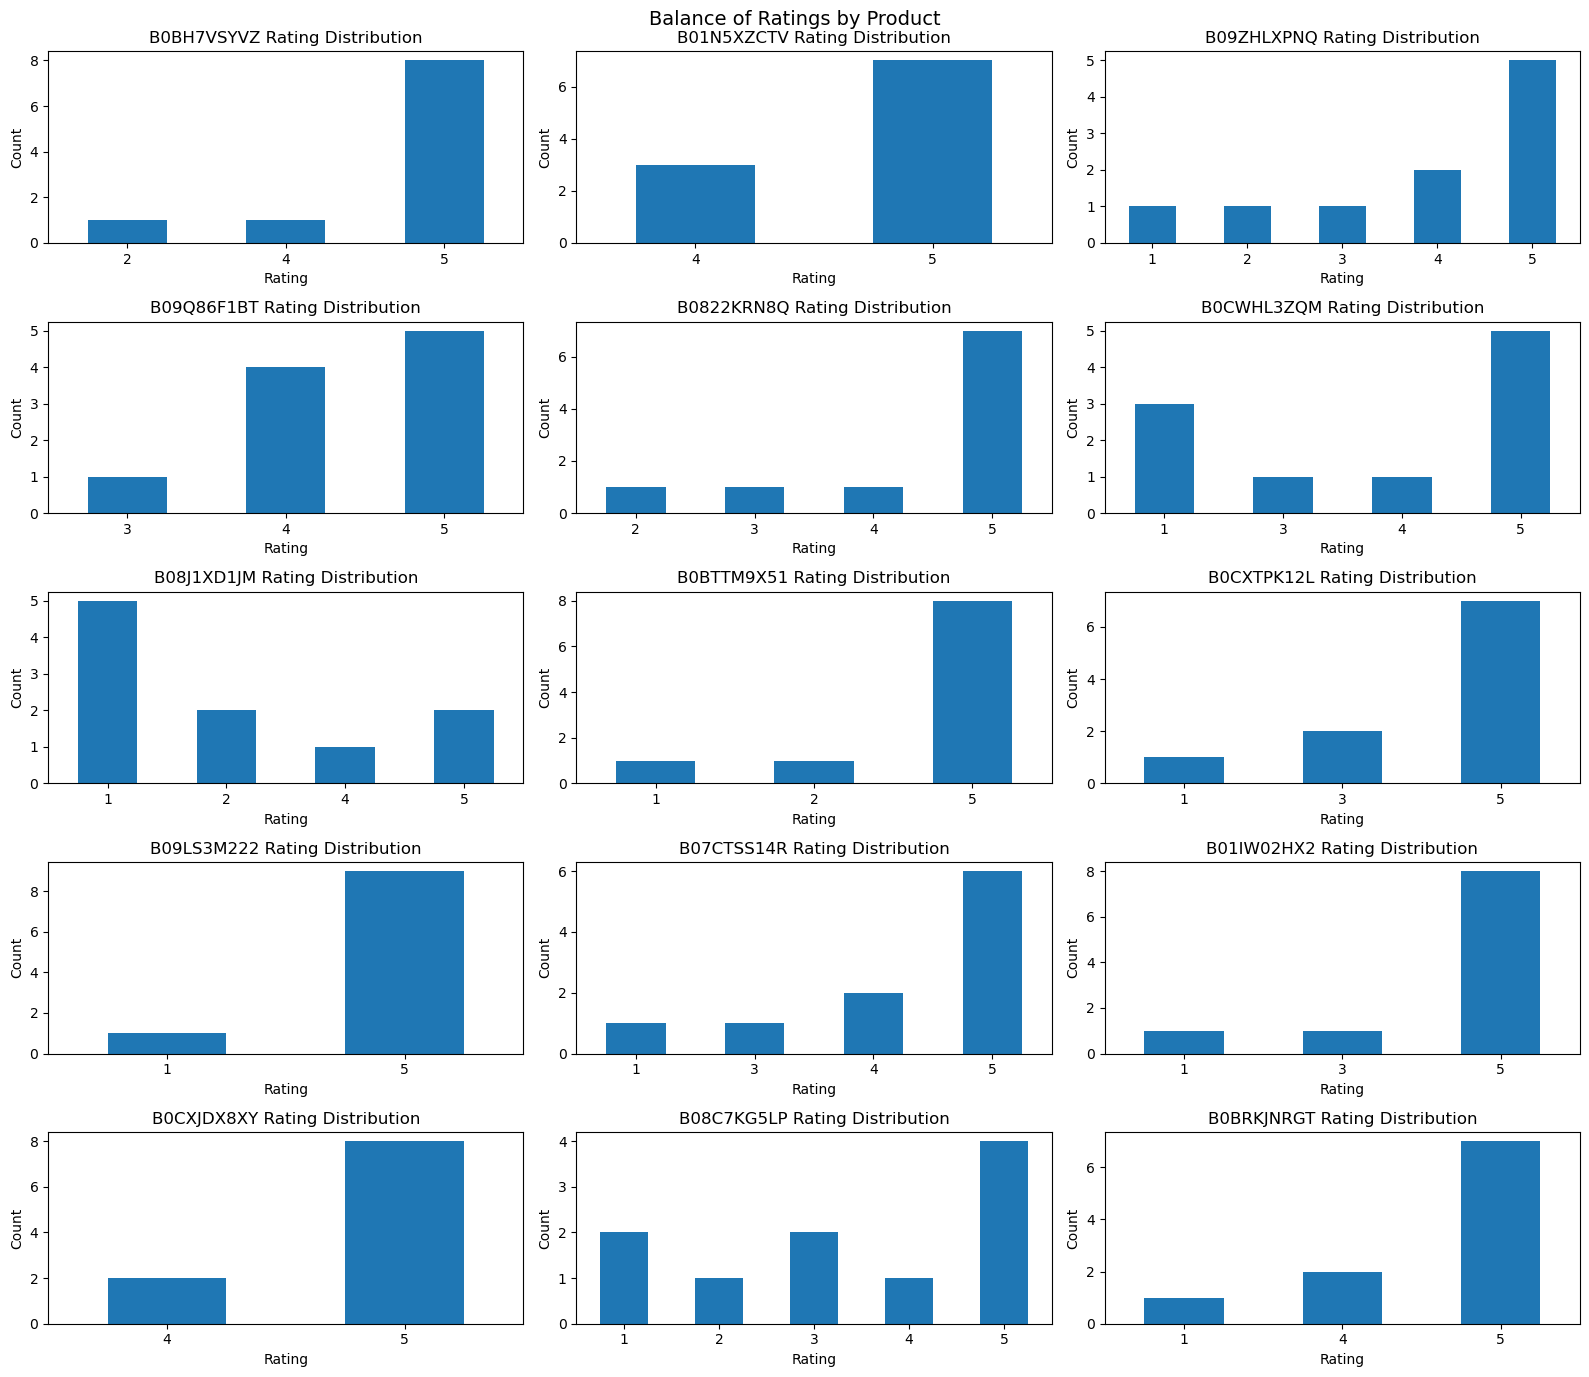

In [13]:
# Finding the balance of ratings for each product
# Finding number of rows of subplots needed
nrows = int(len(df['asin'].unique())/3)
if len(df['asin'].unique()) % 3 != 0:
    nrows += 1

# Creating axis for plots
fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(16, 14))
axes = axes.flatten()

fig.suptitle('Balance of Ratings by Product', fontsize=14)

# Creating graph for distribution of rating in each ASIN
for i, asin in enumerate(df['asin'].unique()):
    asin_df = df[df['asin'] == asin]
    
    # Creating bar chart and customising
    asin_df['rating'].value_counts().sort_index().plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'{asin} Rating Distribution')
    axes[i].set_xlabel('Rating')
    axes[i].set_ylabel('Count')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=0)

# Removing any unused axis
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

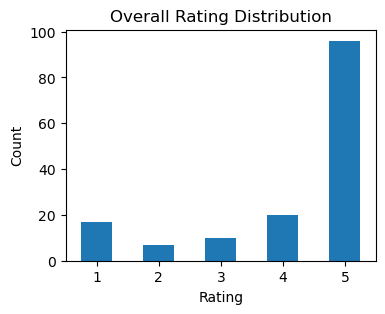

In [14]:
# Finding overall balance of ratings
plt.figure(figsize=(4, 3))
df['rating'].value_counts().sort_index().plot(kind='bar')
plt.title(f'Overall Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [15]:
# Printing the overall number of each rating
df['rating'].value_counts()

rating
5    96
4    20
1    17
3    10
2     7
Name: count, dtype: int64

In [16]:
# Finding number of reviews scraped for each ASIN
df['asin'].value_counts()

asin
B0BH7VSYVZ    10
B01N5XZCTV    10
B09ZHLXPNQ    10
B09Q86F1BT    10
B0822KRN8Q    10
B0CWHL3ZQM    10
B08J1XD1JM    10
B0BTTM9X51    10
B0CXTPK12L    10
B09LS3M222    10
B07CTSS14R    10
B01IW02HX2    10
B0CXJDX8XY    10
B08C7KG5LP    10
B0BRKJNRGT    10
Name: count, dtype: int64

In [17]:
# Adding column signifying length of text
df['length'] = df['review_text'].str.len()

<Axes: >

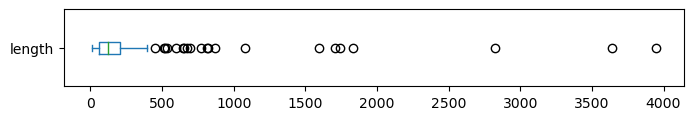

In [18]:
# Plotting box plot for length of text
df['length'].plot(kind='box', vert=False, figsize=(8, 1))

<Axes: ylabel='Frequency'>

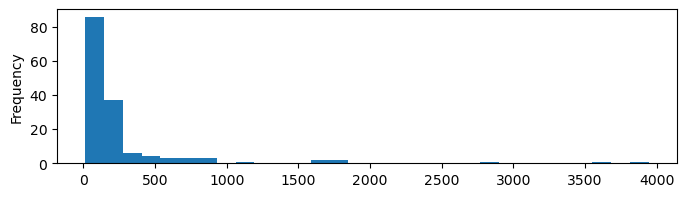

In [19]:
# Plotting histogram for length of text
df['length'].plot(kind='hist', bins=30, figsize=(8,2))

In [20]:
# Calculating summary statistics
df.describe().T

,count,mean,min,25%,50%,75%,max,std
rating,150.0,4.14,1.0,4.0,5.0,5.0,5.0,1.38074
review_date,150,2024-05-09 21:45:36,2023-08-22 00:00:00,2024-05-17 00:00:00,2024-05-30 00:00:00,2024-06-02 00:00:00,2024-06-06 00:00:00,NaN
length,150.0,281.54,12.0,63.25,124.5,207.5,3946.0,558.159158


#### Text Processing -

In [125]:
# Defining lowercase function
lower = str.lower

In [22]:
# Defining tokenizer function (based off white spaces)
tokenizer = nltk.WhitespaceTokenizer()
def tokenize(text):
    tokens = tokenizer.tokenize(text)
    return tokens

In [23]:
# Downloading NLTK stopwords
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))

# Defining remove stop words function
def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\holly\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
# Checking stopwords in list
stopwords

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [30]:
# Defining remove punctuation function
def remove_punc(tokens):
    return [t for t in tokens if t not in string.punctuation]

In [31]:
# Defining function to correct any misspelt words
def correct_spellings(tokens):
    return [Word(token).correct() for token in tokens]

In [32]:
# Creating pipeline for processing text using defined functions
pipeline = [lower, tokenize, remove_stop, remove_punc, correct_spellings]
def prepare(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens

In [33]:
# Running text processing pipeline
df['tokens'] = df['review_text'].apply(prepare, pipeline=pipeline)

In [34]:
# Finding number of tokens and adding to column
df['num_tokens'] = df['tokens'].map(len)

In [35]:
# Checking text has been processed correctly
df.sample(3)

,asin,rating,review_date,review_text,length,tokens,num_tokens
25,B09ZHLXPNQ,3,2024-05-26,Difficult to understand I really tried but cou...,95,"[difficult, understand, really, tried, couldn,...",10
129,B0CXJDX8XY,5,2024-05-19,A decent upgrade to a Pixel 6a So my review is...,1834,"[decent, upgrade, fixed, a, review, comparison...",170
41,B0822KRN8Q,5,2024-06-04,Wonderful I ordered the large to xl but next t...,146,"[wonderful, ordered, large, ll, next, time, or...",19


#### Word Frequency Analysis -

In [38]:
# Finding most frequent tokens
counter = Counter()
for n in range(len(df)):
    counter.update(df['tokens'][n])

# Creating dataframe to store count of words
count_df = pd.DataFrame.from_dict(counter, orient='index', columns=['count'])
count_df = count_df.sort_values('count', ascending = False)
count_df.head(15)

,count
great,50
phone,49
good,43
book,32
a,28
quality,25
really,24
one,24
use,24
well,22


In [43]:
# Removing 'a' and 'also' from the count dataframe
count_df = count_df.drop(['a', 'also'])
count_df.head(15)

,count
great,50
phone,49
good,43
book,32
quality,25
really,24
one,24
use,24
well,22
like,20


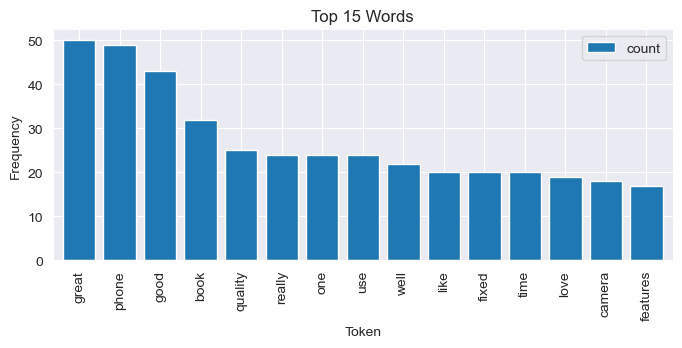

In [44]:
# Creating bar chart for count of words
sns.set_style("darkgrid")
ax = count_df.head(15).plot(kind='bar', width=0.8, figsize=(8,3))
ax.set(xlabel='Token', ylabel='Frequency', title='Top 15 Words')
plt.show()

In [56]:
# Finding month reviews were created
df['review_month'] = df['review_date'].dt.to_period('M')

# Creating dictionary for number of word mentions per month
word_counts_by_month = {}
for index, row in df.iterrows():
    month = row['review_month']
    words = row['tokens']
    if month not in word_counts_by_month:
        word_counts_by_month[month] = Counter()
    word_counts_by_month[month].update(words)

# Converting the count of words by month to dataframe
word_counts_month_df = pd.DataFrame(word_counts_by_month).fillna(0).astype(int)

# Deleting 'a' and 'also' from df
word_counts_month_df = word_counts_month_df.drop(['a', 'also'])

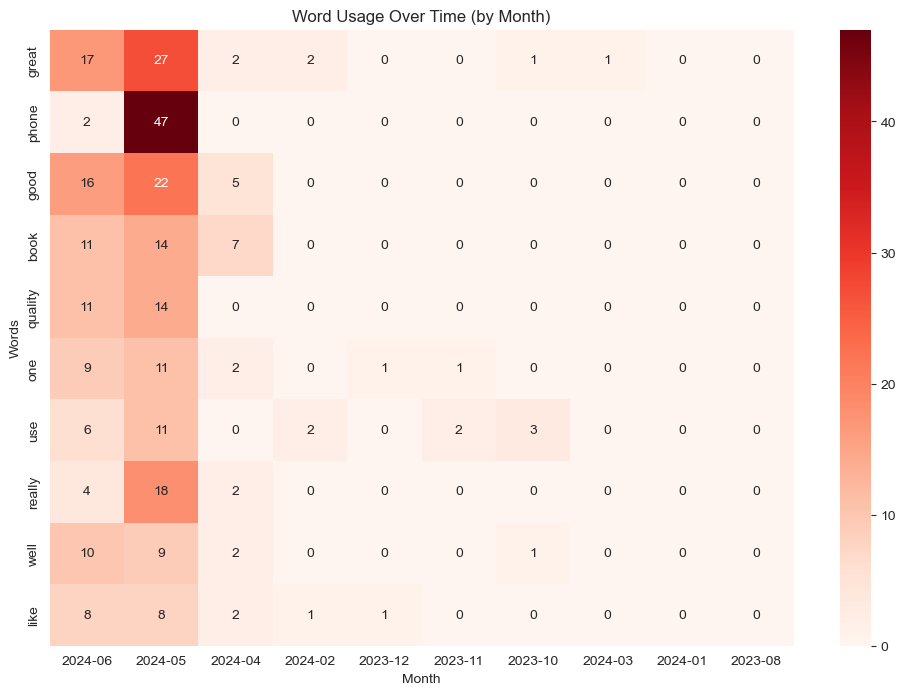

In [57]:
# Plotting heatmap to show words used by month
# Finding most used words to use in heatmap
top_words = word_counts_month_df.sum(axis=1).sort_values(ascending=False).head(10).index
top_word_counts_month_df = word_counts_month_df.loc[top_words]

# Creating and customising heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(top_word_counts_month_df, cmap="Reds", annot=True, fmt="d")
plt.title("Word Usage Over Time (by Month)")
plt.xlabel("Month")
plt.ylabel("Words")
plt.show()

#### TF-IDF -

In [68]:
# Calculating DF and IDF values and adding to dataframe
counter = Counter()
for doc in df['tokens']:
    tokens = doc
    counter.update(tokens)

idf_df = pd.DataFrame.from_dict(counter, orient='index', columns=['df'])
idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1
idf_df.index.name = 'token'

In [69]:
# Printing sample of IDF dataframe
idf_df.sample(5)

,df,idf
token,,
sectional,1,5.110635
purchasing,2,4.417488
while,1,5.110635
weekend,1,5.110635
likes,1,5.110635


In [70]:
# Calculating TF-IDF values and adding to same dataframe
tf_idf_df = count_df.join(idf_df)
tf_idf_df['tf-idf'] = tf_idf_df['count']*tf_idf_df['idf']
tf_idf_df.head()

,count,df,idf,tf-idf
great,50,50,1.198612,59.930614
phone,49,49,1.218815,59.721935
good,43,43,1.349435,58.025713
book,32,32,1.644899,52.636781
quality,25,25,1.891759,47.293987


#### N-Grams -

In [71]:
# Defining function for bigrams
def bigrams(tokens, n=2, sep=' '):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])]

In [72]:
# Finding bigrams for each review
df['bigrams'] = df['tokens'].apply(bigrams)
df.head()

,asin,rating,review_date,review_text,length,tokens,num_tokens,review_month,bigrams
0,B0BH7VSYVZ,5,2024-06-06,wow! Woah! What a rollercoaster of a book!It w...,307,"[now, noah, rollercoaster, booklet, creep, int...",29,2024-06,"[now noah, noah rollercoaster, rollercoaster b..."
1,B0BH7VSYVZ,2,2024-06-06,Poor writing Lack of any character depth or a ...,62,"[poor, writing, lack, character, depth, challe...",7,2024-06,"[poor writing, writing lack, lack character, c..."
2,B0BH7VSYVZ,5,2024-06-05,"Amazing!! Amazing book, had me gripped from th...",136,"[amazing, amazing, book, gripped, first, word!...",14,2024-06,"[amazing amazing, amazing book, book gripped, ..."
3,B0BH7VSYVZ,5,2024-06-05,Great story I loved this book. Lisa Jewell has...,72,"[great, story, loved, book, lisa, jewel, writt...",9,2024-06,"[great story, story loved, loved book, book li..."
4,B0BH7VSYVZ,5,2024-06-04,Brilliant What a cracker of a book. Lisa Jewe...,65,"[brilliant, cracked, book, lisa, jewel, best]",6,2024-06,"[brilliant cracked, cracked book, book lisa, l..."


In [73]:
bigram_counter = Counter()
for n in range(len(df)):
    bigram_counter.update(df['bigrams'][n])

In [74]:
bigram_count_df = pd.DataFrame.from_dict(bigram_counter, orient='index', columns=['count'])
bigram_count_df = bigram_count_df.sort_values('count', ascending = False)
bigram_count_df.head()

,count
fixed a,14
air frye,10
goose fixed,9
battery life,6
old phone,5


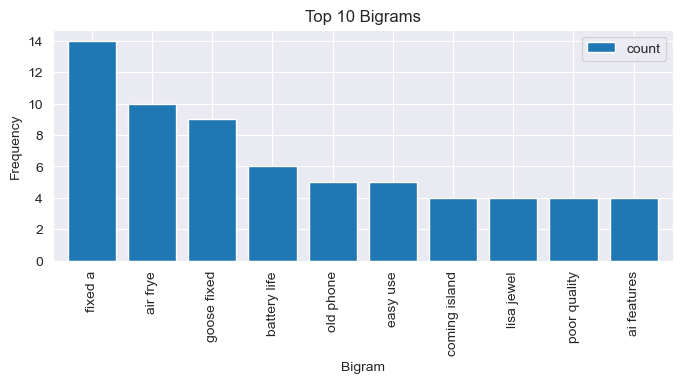

In [75]:
# Creating bar chart for count of bigrams
sns.set_style("darkgrid")
ax = bigram_count_df.head(10).plot(kind='bar', width=0.8, figsize=(8,3))
ax.set(xlabel='Bigram', ylabel='Frequency', title='Top 10 Bigrams')
plt.show()

In [76]:
# Defining function for trigrams
def trigrams(tokens, n=3, sep=' '):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])]

In [77]:
# Finding trigrams for each review
df['trigrams'] = df['tokens'].apply(trigrams)
df

,asin,rating,review_date,review_text,length,tokens,num_tokens,review_month,bigrams,trigrams
0,B0BH7VSYVZ,5,2024-06-06,wow! Woah! What a rollercoaster of a book!It w...,307,"[now, noah, rollercoaster, booklet, creep, int...",29,2024-06,"[now noah, noah rollercoaster, rollercoaster b...","[now noah rollercoaster, noah rollercoaster bo..."
1,B0BH7VSYVZ,2,2024-06-06,Poor writing Lack of any character depth or a ...,62,"[poor, writing, lack, character, depth, challe...",7,2024-06,"[poor writing, writing lack, lack character, c...","[poor writing lack, writing lack character, la..."
2,B0BH7VSYVZ,5,2024-06-05,"Amazing!! Amazing book, had me gripped from th...",136,"[amazing, amazing, book, gripped, first, word!...",14,2024-06,"[amazing amazing, amazing book, book gripped, ...","[amazing amazing book, amazing book gripped, b..."
3,B0BH7VSYVZ,5,2024-06-05,Great story I loved this book. Lisa Jewell has...,72,"[great, story, loved, book, lisa, jewel, writt...",9,2024-06,"[great story, story loved, loved book, book li...","[great story loved, story loved book, loved bo..."
4,B0BH7VSYVZ,5,2024-06-04,Brilliant What a cracker of a book. Lisa Jewe...,65,"[brilliant, cracked, book, lisa, jewel, best]",6,2024-06,"[brilliant cracked, cracked book, book lisa, l...","[brilliant cracked book, cracked book lisa, bo..."
...,...,...,...,...,...,...,...,...,...,...
145,B0BRKJNRGT,5,2024-05-31,Good product Exactly what I wanted really good...,54,"[good, product, exactly, wanted, really, good,...",7,2024-05,"[good product, product exactly, exactly wanted...","[good product exactly, product exactly wanted,..."
146,B0BRKJNRGT,5,2024-05-30,"Really fast Does what it days on the tin, but ...",118,"[really, fast, days, tiny, one, actually, real...",12,2024-05,"[really fast, fast days, days tiny, tiny one, ...","[really fast days, fast days tiny, days tiny o..."
147,B0BRKJNRGT,4,2024-05-29,Great product It does as it says on the box bu...,170,"[great, product, says, box, wastage, seems, li...",18,2024-05,"[great product, product says, says box, box wa...","[great product says, product says box, says bo..."
148,B0BRKJNRGT,5,2024-05-29,Great transaction. Does what it says. Cheaper ...,56,"[great, transaction, says, cheaper, shop]",5,2024-05,"[great transaction, transaction says, says che...","[great transaction says, transaction says chea..."


In [78]:
trigram_counter = Counter()
for n in range(len(df)):
    trigram_counter.update(df['trigrams'][n])

In [79]:
trigram_count_df = pd.DataFrame.from_dict(trigram_counter, orient='index', columns=['count'])
trigram_count_df = trigram_count_df.sort_values('count', ascending = False)
trigram_count_df.head()

,count
goose fixed a,7
smells like popcorn,2
leggings have ever,2
smartphone delivers fronts,2
high-quality smartphone delivers,2


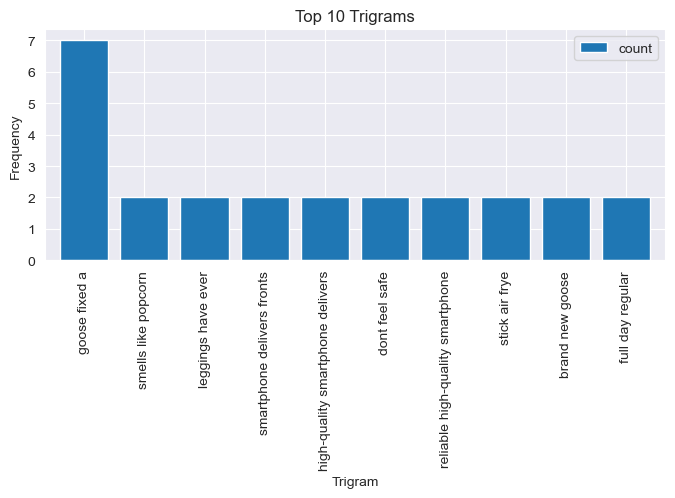

In [80]:
# Creating bar chart for count of bigrams
sns.set_style("darkgrid")
ax = trigram_count_df.head(10).plot(kind='bar', width=0.8, figsize=(8,3))
ax.set(xlabel='Trigram', ylabel='Frequency', title='Top 10 Trigrams')
plt.show()

#### Sentiment Analysis -

In [82]:
df.loc[df['rating'] > 3, 'sentiment'] = 'positive'
df.loc[df['rating'] < 3, 'sentiment'] = 'negative'
df.loc[df['rating'] == 3, 'sentiment'] = 'neutral'

In [84]:
df['sentiment'].value_counts()

sentiment
positive    116
negative     24
neutral      10
Name: count, dtype: int64

In [85]:
# Splitting data into test and train
X_train, X_test, Y_train, Y_test = train_test_split(df['review_text'],
                                                    df['sentiment'],
                                                    test_size=0.2,
                                                    random_state=123,
                                                    stratify=df['sentiment'])

In [86]:
# Printing x train sample
X_train

132    Annoying if you switch devices often Sound qua...
55     Sack-like but breathable Baggy loose sack-like...
104    If you want a scrub, by a different product......
73     I really think this one was fake The one I rec...
52                                      Poor Looks cheap
                             ...                        
67     Poor quality Does not remove dirt or sweat lik...
15                                   Good book Good book
75     Love it Smells really lovely and lasts. Clothe...
25     Difficult to understand I really tried but cou...
20     Beautiful What Grace and beauty this book port...
Name: review_text, Length: 120, dtype: object

In [87]:
# Printing x test sample
X_test

11     A compelling Grisham tale This is a well devel...
19     Good storyline Grisham books sometimes peter o...
31                            Waterproof boots Like this
111    Second pallet This is my 2nd palletLove the co...
47     SINOPHANT High Waisted Leggings for Women I fo...
16           everything liked everything delivery book +
122    Brillant Camera & fun AI I have always had var...
45        Leggings Amazing quality and fit for the price
70                                    COMFORT GOOD PRICE
113    Ok Too small size plate. I think according to ...
26     The horrors of the first world war Homosexual ...
78     value for money, top quality. Wait for the rig...
38     Good buy Bought for use in a festival, I was o...
4      Brilliant What a cracker of a book.  Lisa Jewe...
131    one of the best headphone I've ever had so com...
101    Amazing scent Change ur location to the US Ama...
138    Not recommended I regret buying these headphon...
53     Very poor quality Got li

In [88]:
# Printing y train sample
Y_train

132    positive
55      neutral
104    positive
73     negative
52     negative
         ...   
67     negative
15     positive
75     positive
25      neutral
20     positive
Name: sentiment, Length: 120, dtype: object

In [89]:
Y_train.value_counts()

sentiment
positive    93
negative    19
neutral      8
Name: count, dtype: int64

In [90]:
# Printing y test sample
Y_test

11     positive
19     positive
31     positive
111    positive
47      neutral
16     positive
122    positive
45     positive
70     positive
113     neutral
26     negative
78     positive
38     positive
4      positive
131    positive
101    positive
138    negative
53     negative
142    positive
95     negative
69     negative
146    positive
120    positive
24     positive
100    positive
125    positive
141    positive
85     positive
92     positive
99     positive
Name: sentiment, dtype: object

In [91]:
Y_test.value_counts()

sentiment
positive    23
negative     5
neutral      2
Name: count, dtype: int64

In [92]:
# Vectorising text data
tfidf = TfidfVectorizer()
X_train_tf = tfidf.fit_transform(X_train)
X_test_tf = tfidf.transform(X_test)

In [93]:
# Training model
model1 = LinearSVC()
model1.fit(X_train_tf, Y_train)

C:\Users\holly\anaconda3\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC()

In [94]:
# Predicting the test data
Y_pred = model1.predict(X_test_tf)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred))

Accuracy Score -  0.8333333333333334


In [106]:
# Adding predicted and actual sentiment to df
results = pd.DataFrame({'text': X_test, 'actual': Y_test, 'predicted': Y_pred})
results.head()

,text,actual,predicted
11,A compelling Grisham tale This is a well devel...,positive,positive
19,Good storyline Grisham books sometimes peter o...,positive,positive
31,Waterproof boots Like this,positive,positive
111,Second pallet This is my 2nd palletLove the co...,positive,positive
47,SINOPHANT High Waisted Leggings for Women I fo...,neutral,positive


In [97]:
model2 = RandomForestClassifier()
model2.fit(X_train_tf, Y_train)

RandomForestClassifier()

In [98]:
# Predicting the test data
Y_pred = model2.predict(X_test_tf)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred))

Accuracy Score -  0.7666666666666667


In [107]:
# Adding predicted and actual sentiment to df
results2 = pd.DataFrame({'text': X_test, 'actual': Y_test, 'predicted': Y_pred})
results2.head()

,text,actual,predicted
11,A compelling Grisham tale This is a well devel...,positive,positive
19,Good storyline Grisham books sometimes peter o...,positive,positive
31,Waterproof boots Like this,positive,positive
111,Second pallet This is my 2nd palletLove the co...,positive,positive
47,SINOPHANT High Waisted Leggings for Women I fo...,neutral,positive


In [110]:
model3 = LogisticRegression()
model3.fit(X_train_tf, Y_train)

LogisticRegression()

In [111]:
# Predicting the test data
Y_pred = model3.predict(X_test_tf)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred))

Accuracy Score -  0.7666666666666667


In [112]:
# Adding predicted and actual sentiment to df
results3 = pd.DataFrame({'text': X_test, 'actual': Y_test, 'predicted': Y_pred})
results3.head()

,text,actual,predicted
11,A compelling Grisham tale This is a well devel...,positive,positive
19,Good storyline Grisham books sometimes peter o...,positive,positive
31,Waterproof boots Like this,positive,positive
111,Second pallet This is my 2nd palletLove the co...,positive,positive
47,SINOPHANT High Waisted Leggings for Women I fo...,neutral,positive
